In [1]:
import os
import json
import itertools
import random
from collections import Counter
from tqdm import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

from esper.widget import *
import esper.face_embeddings as face_embeddings

def query_faces(ids):
    faces = Face.objects.filter(id__in=ids)
    return faces.values(
        'id', 'bbox_y1', 'bbox_y2', 'bbox_x1', 'bbox_x2',
        'frame__number', 'frame__video__id', 'frame__video__fps',
        'shot__min_frame', 'shot__max_frame')

def query_faces_result(faces, expand_bbox=0.05):
    """Replaces qs_to_result"""
    result = []
    for face in faces:
        if (face.get('shot__min_frame') is not None and
                face.get('shot__max_frame') is not None):
            min_frame = int(
                (face['shot__min_frame'] +
                 face['shot__max_frame']) / 2)
        else:
            min_frame = face['frame__number']
        face_result = {
            'type': 'flat', 'label': '',
            'elements': [{
                'objects': [{
                    'id': face['id'],
                    'background': False,
                    'type': 'bbox',
                    'bbox_y1': max(face['bbox_y1'] - expand_bbox, 0),
                    'bbox_y2': min(face['bbox_y2'] + expand_bbox, 1),
                    'bbox_x1': max(face['bbox_x1'] - expand_bbox, 0),
                    'bbox_x2': min(face['bbox_x2'] + expand_bbox, 1),
                }],
                'min_frame': min_frame,
                'video': face['frame__video__id']
            }]
        }
        result.append(face_result)
    return {'type': 'Face', 'count': 0, 'result': result}

def plot_confusion_matrix(y_truth, y_pred, normalize=True):
    cm = confusion_matrix(y_truth, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    classes = ['Non-black', 'Black']
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Black vs. non-black confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Hand label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def print_pred_dist(pred):
    n = len(pred)
    counts = Counter([t[1] for t in pred])
    for k in sorted(counts):
        print('', '{:0.2f}'.format(k), counts[k] / n)

In [20]:
with open('/app/data/black.1k.random.json') as f:
    hand_labels_train = {int(k): int(v) for k, v in json.load(f).items()}
train_ids = [i for i in hand_labels_train]
train_y = [hand_labels_train[i] for i in train_ids]
del hand_labels_train
    
with open('/app/data/black.dan.250.random.json') as f:
    hand_labels_test = {int(k): int(v) for k, v in json.load(f).items()}
test_ids = [i for i in hand_labels_test]
test_y = [hand_labels_test[i] for i in test_ids]
del hand_labels_test

Train accuracy: 0.9733224603914259
Train f1-score: 0.8876900441392841
Non-normalized train confusion matrix:


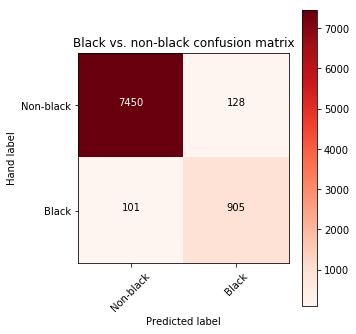

Normalized train confusion matrix:


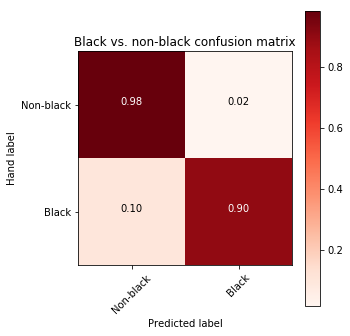

Test accuracy: 0.9588516746411483
Test f1-score: 0.8447653429602888
Non-normalized test confusion matrix:


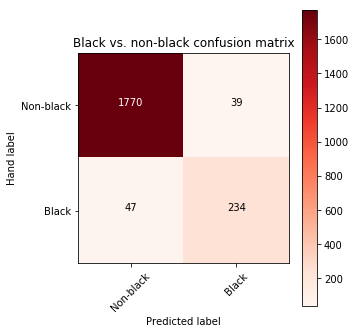

Normalized test confusion matrix:


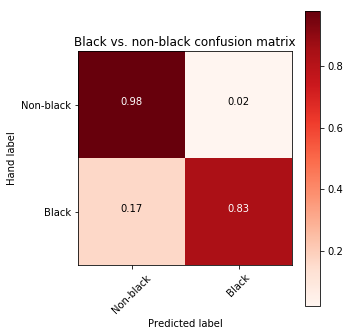

Test accuracy (on unknown identities only): 0.9464751958224543
Test f1-score (on unknown identities only): 0.7980295566502463
Non-normalized test confusion matrix (on unknown identities only):


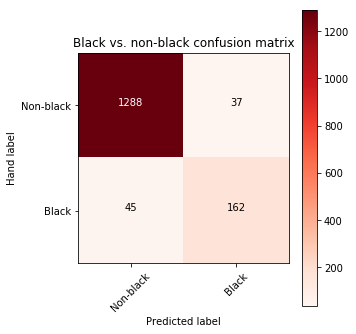

Normalized test confusion matrix (on unknown identities only):


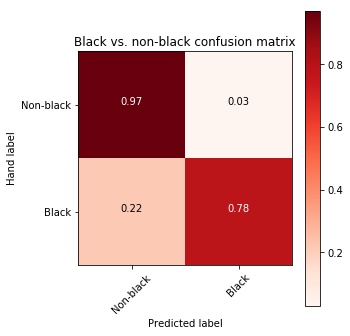

In [22]:
PRED_THRESHOLD = 0.3
K = 15

test_pred_r = face_embeddings.knn_predict(
    train_ids, train_y, k=K, ids=test_ids)
test_pred_d = {k: 0 if v < PRED_THRESHOLD else 1
               for k, v in test_pred_r}
test_pred = [test_pred_d[i] for i in test_ids]

train_pred_r = face_embeddings.knn_predict(
    train_ids, train_y, k=K, ids=train_ids)
train_pred_d = {k: 0 if v < PRED_THRESHOLD else 1
                for k, v in train_pred_r}
train_pred = [train_pred_d[i] for i in train_ids]

# print('Train pred dist:')
# print_pred_dist(train_pred_r)
print('Train accuracy:', accuracy_score(train_y, train_pred))
print('Train f1-score:', f1_score(train_y, train_pred))
print('Non-normalized train confusion matrix:')
plot_confusion_matrix(train_y, train_pred, False)
print('Normalized train confusion matrix:')
plot_confusion_matrix(train_y, train_pred)

# print('Test pred dist:')
# print_pred_dist(test_pred_r)
print('Test accuracy:', accuracy_score(test_y, test_pred))
print('Test f1-score:', f1_score(test_y, test_pred))
print('Non-normalized test confusion matrix:')
plot_confusion_matrix(test_y, test_pred, False)
print('Normalized test confusion matrix:')
plot_confusion_matrix(test_y, test_pred)

test_ids_unk = {
    fi['face__id'] for fi in FaceIdentity.objects.filter(
        face__id__in=test_ids, probability__gt=0.5
    ).values('face__id')
}
test_y_unk = [
    test_y[i] for i, j in enumerate(test_ids) 
    if j not in test_ids_unk
]
test_pred_unk = [
    test_pred[i] for i, j in enumerate(test_ids) 
    if j not in test_ids_unk
]
print('Test accuracy (on unknown identities only):', 
      accuracy_score(test_y_unk, test_pred_unk))
print('Test f1-score (on unknown identities only):', 
      f1_score(test_y_unk, test_pred_unk))
print('Non-normalized test confusion matrix (on unknown identities only):')
plot_confusion_matrix(test_y_unk, test_pred_unk, False)
print('Normalized test confusion matrix (on unknown identities only):')
plot_confusion_matrix(test_y_unk, test_pred_unk)

# False Positives

In [ ]:
# data_iter = zip(test_ids, test_pred, test_y)
data_iter = zip(train_ids, train_pred, train_y)

fp_ids = [i for i, y_pred, y_true in data_iter
          if y_pred == 1 and y_true == 0]
fp_faces = query_faces(fp_ids)
fp_widget = esper_widget(query_faces_result(fp_faces))
fp_widget

In [ ]:
fp_selected = [fp_faces[i]['id'] for i in fp_widget.selected]
fp_selected

# False Negative

In [ ]:
# data_iter = zip(test_ids, test_pred, test_y)
data_iter = zip(train_ids, train_pred, train_y)

fn_ids = [i for i, y_pred, y_true in data_iter
          if y_pred == 0 and y_true == 1]
fn_faces = query_faces(fn_ids)
fn_widget = esper_widget(query_faces_result(fn_faces))
fn_widget

In [ ]:
fn_selected = [fn_faces[i]['id'] for i in fn_widget.selected]
fn_selected

# Run KNN on Entire Dataset

In [9]:
RACE_PRED_DIR = '/app/data/race_pred/'
if not os.path.exists(RACE_PRED_DIR):
    os.makedirs(RACE_PRED_DIR)

In [5]:
batch_size = 100000
max_idx = face_embeddings.count()
max_face_id = face_embeddings.ids(max_idx - 1, 1)[0]
# print('Max face id:', max_face_id)
for i in tqdm(range(0, max_face_id, batch_size)):
    batch_path = os.path.join(RACE_PRED_DIR, '{}.json'.format(i))
    if not os.path.exists(batch_path):
        batch_face_ids = list(range(i, i + batch_size))
        batch_face_ids = [
            a for a, b in zip(batch_face_ids, face_embeddings.exists(batch_face_ids))
            if b == True
        ]
        batch_pred = face_embeddings.knn_predict(
            train_ids, train_y, k=15, ids=batch_face_ids)
        with open(batch_path, 'w') as f:
            json.dump(batch_pred, f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3456/3456 [00:00<00:00, 60597.19it/s]


# Collapse into a single file

In [ ]:
MIN_SCORE_THRESHOLD = 0

with open('/app/data/black_face_ids.csv', 'w') as out_f:
    out_f.write('face_id,score\n')
    count = 0
    for batch_file in tqdm(os.listdir(RACE_PRED_DIR), 
                           desc='Saving batches'):
        batch_path = os.path.join(RACE_PRED_DIR, batch_file)
        with open(batch_path) as batch_f:
            batch_pred = json.load(batch_f)
            for a, b in batch_pred:
                if b > MIN_SCORE_THRESHOLD:
                    out_f.write('{},{}\n'.format(a, round(b, 2)))
                    count += 1
    print('Wrote {} labels'.format(count))
                    

# Save labels to the database

In [11]:
black_tag, created = Tag.objects.get_or_create(name='black')
if created:
    print('Created:', black_tag.name)
black_labeler, created = Labeler.objects.get_or_create(name='race:knn-black')
if created:
    print('Created:', black_labeler.name)

In [12]:
valid_face_ids = set()
with open('/app/data/pg/query_face.csv') as f:
    for i, line in enumerate(f):
        line = line.strip()
        if line == '' or i == 0:
            continue
        face_id = int(line.split(',', 1)[0])
        valid_face_ids.add(face_id)
print('{} valid face ids'.format(len(valid_face_ids)))

344559738 valid face ids


In [ ]:
MIN_SCORE_THRESHOLD = 0.3

for batch_file in sorted(os.listdir(RACE_PRED_DIR)):
    batch_path = os.path.join(RACE_PRED_DIR, batch_file)
    batch_tags = []
    already_checked = False
    with open(batch_path) as batch_f:
        batch_pred = json.load(batch_f)
        for a, b in batch_pred:
            if a in valid_face_ids and b >= MIN_SCORE_THRESHOLD:
                if not already_checked:
                    already_checked = True
                    # Check if the batch already exists
                    try:
                        FaceTag.objects.filter(
                            face__id=a, tag=black_tag, labeler=black_labeler
                        ).get()
                        print('Already saved:', batch_file)
                        break
                    except:
                        print('Not yet saved:', batch_file)

                batch_tags.append(
                    FaceTag(face_id=a, score=b, tag=black_tag,
                            labeler=black_labeler))        
    if len(batch_tags) > 0:
        FaceTag.objects.bulk_create(batch_tags)

Already saved: 0.json
Already saved: 100000.json
Already saved: 1000000.json
Already saved: 10000000.json
Already saved: 100000000.json
Already saved: 100100000.json
Already saved: 100200000.json
Already saved: 100300000.json
Already saved: 100400000.json
Already saved: 100500000.json
Already saved: 100600000.json
Already saved: 100700000.json
Already saved: 100800000.json
Already saved: 100900000.json
